## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

##### 7.1.1 Загрузка и подготовка данных

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,0]
print(madrid.shape)

(25000,)


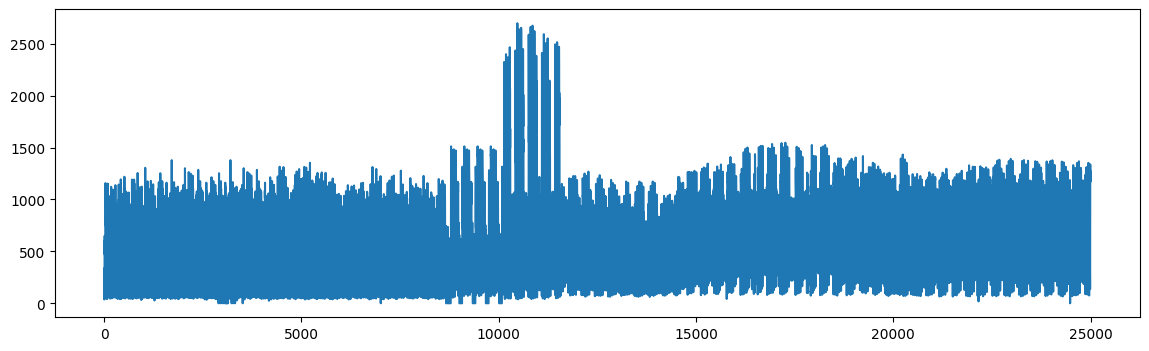

In [3]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значений
   
Процент пропущенных значений должен регулироваться отдельным параметром.


In [196]:
import torch

def add_nan(x, percent = 0.25):
    index = []
    xx = x.copy() if type(x) != torch.Tensor else x.clone()
    for i in range(len(x)):
        if np.random.random() < percent:
            xx[i] = np.nan
            index.append(i)
    return xx, np.array(index)


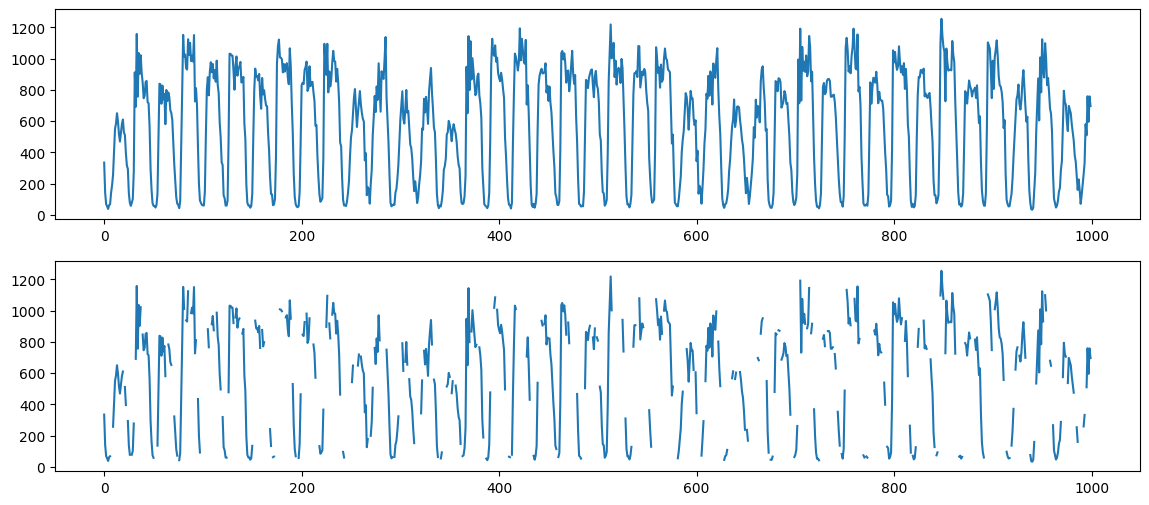

In [5]:
madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_with_nan[:1000])
plt.show()

In [6]:
recovery = {}

##### 7.1.2 Заполнение существующими значениями ряда


In [7]:
madrid_mean = madrid_with_nan.copy()
madrid_mean[index] = np.nanmean(madrid_mean)
recovery['mean'] = madrid_mean

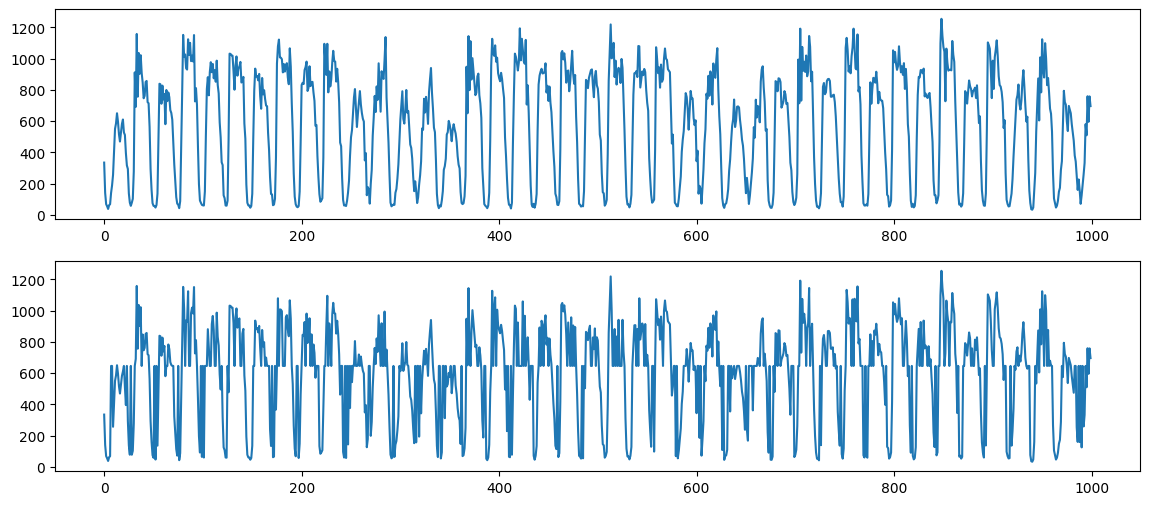

In [8]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_mean[:1000])
plt.show()

In [9]:
madrid_median = madrid_with_nan.copy()
madrid_median[index] = np.nanmedian(madrid_median)

In [10]:
recovery['median'] = madrid_median

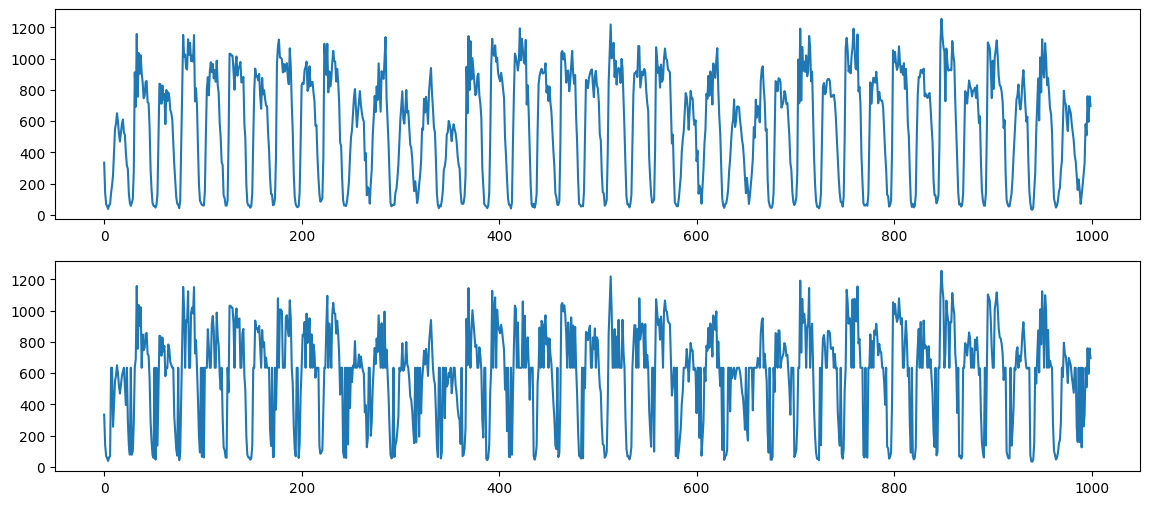

In [11]:
#madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_median[:1000])
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7.1*** и проведите постановление данных, сохранив результаты восстановления.

In [42]:
#Метод, заполняющий NAN-значения последним не NAN-значением. [5, nan, nan, nan, 7, nan,  9] -> [5, 5, 5, 5, 7, 7, 9]
madrid_ffill = madrid_with_nan.copy()

def fill_forward(arr):
    #valid_index = ~np.isnan(arr)
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.size),0)
    np.maximum.accumulate(idx, out=idx)
    out = arr[idx]
    return out
madrid_ffill = fill_forward(madrid_ffill)

In [44]:
recovery['ffill'] = madrid_ffill

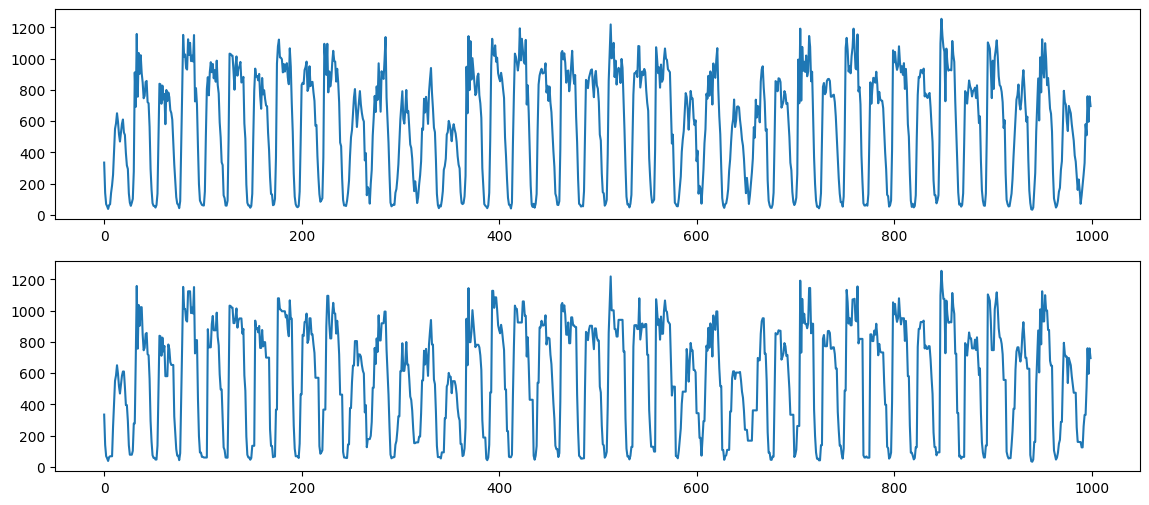

In [45]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_ffill[:1000])
plt.show()

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов восстановления второй группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [28]:
from sklearn.impute import KNNImputer

In [76]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:  
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:    
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)
#madrid_slice = rolling_window(madrid_with_nan, 10)


In [105]:
madrid_slice = rolling_window(madrid_with_nan, 100)
imputer = KNNImputer(n_neighbors=5)
madrid_knn = imputer.fit_transform(madrid_slice)
madrid_knn = madrid_knn.flatten()

In [93]:
recovery['knn'] = madrid_knn

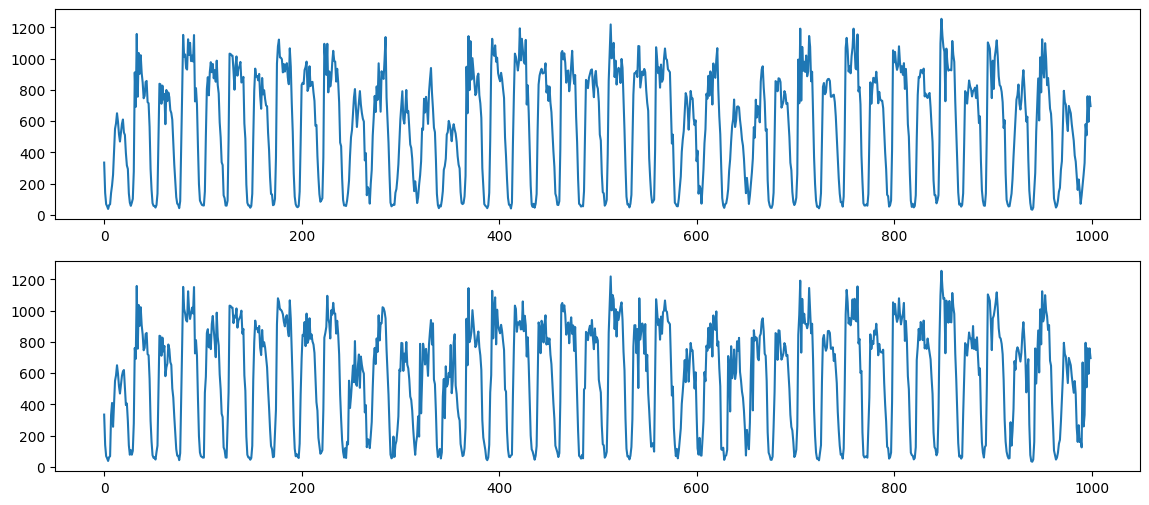

In [106]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_knn[:1000])
plt.show()

##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов восстановления третей группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [ ]:
!pip install fancyimpute

In [49]:
from fancyimpute import IterativeSVD
from fancyimpute import IterativeSVD

In [50]:
from sklearn.metrics import mean_squared_error

In [161]:
imputer = IterativeSVD(rank=3, verbose=False)
madrid_svd_window = rolling_window(madrid_with_nan, 10)
madrid_svd = imputer.fit_transform(madrid_svd_window)
madrid_svd = madrid_svd.flatten()#madrid_svd.mean(axis=1)

In [163]:
recovery['svd'] = madrid_svd

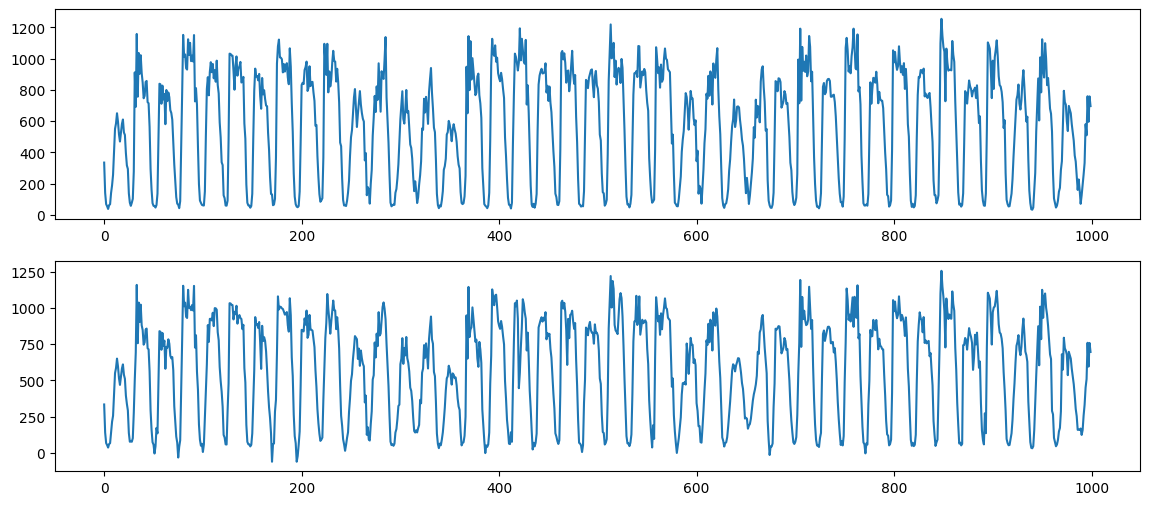

In [162]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_svd[:1000])
plt.show()

##### 7.1.5 Сравнение результатов восстановления.

Для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов.
Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



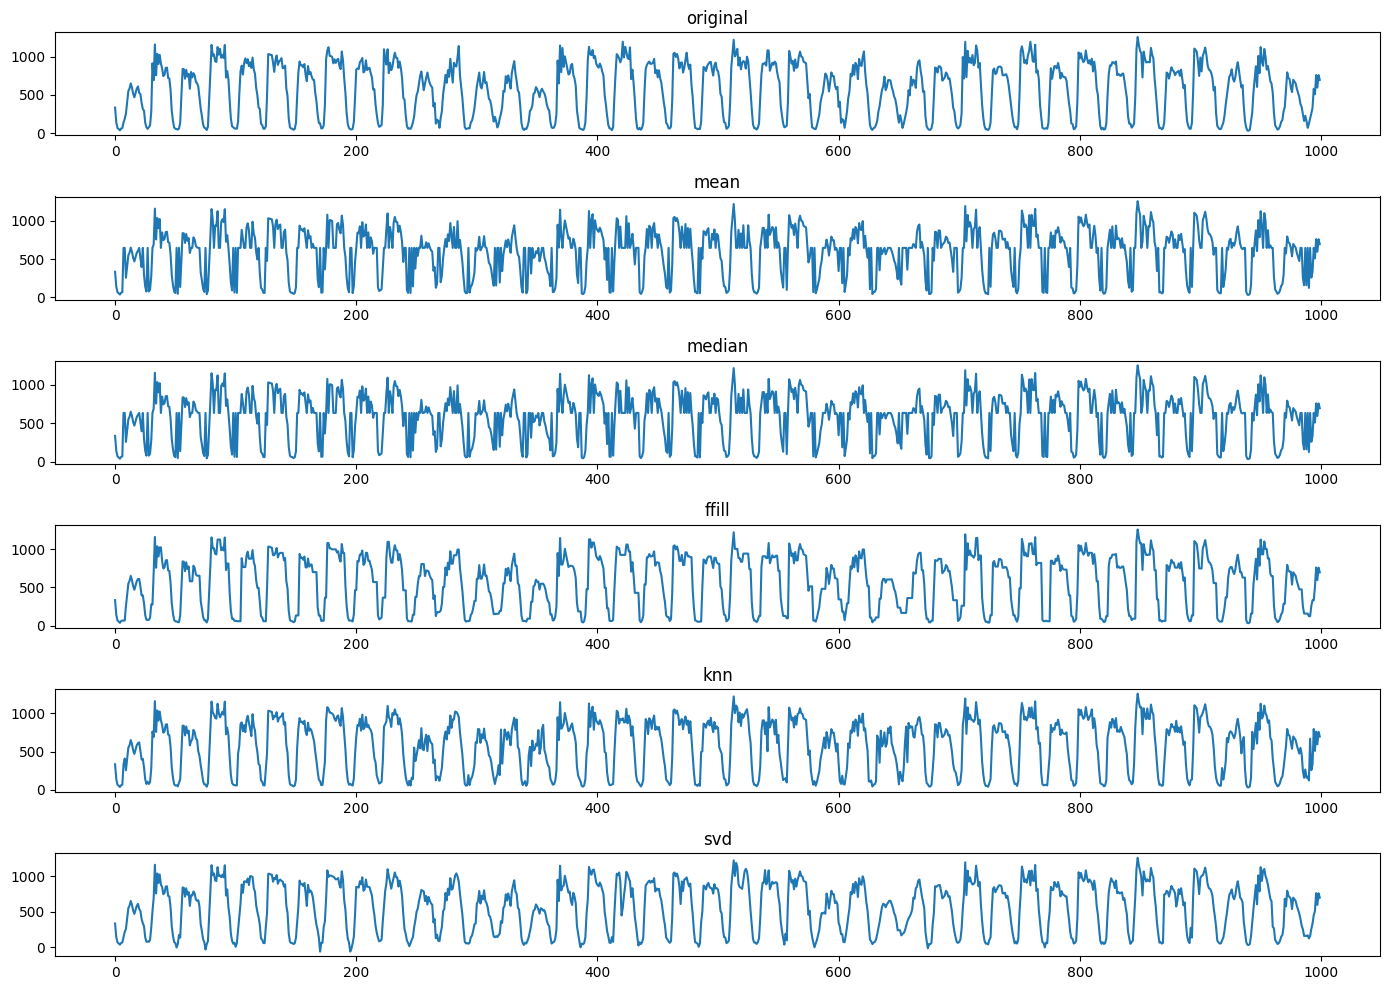

In [170]:
fig, ax =  plt.subplots(figsize=(14,10),ncols=1,nrows=6)
ax[0].plot(madrid[:1000])
ax[0].title.set_text('original')
ax[1].plot(madrid_mean[:1000])
ax[1].title.set_text('mean')
ax[2].plot(madrid_median[:1000])
ax[2].title.set_text('median')
ax[3].plot(madrid_ffill[:1000])
ax[3].title.set_text('ffill')
ax[4].plot(madrid_knn[:1000])
ax[4].title.set_text('knn')
ax[5].plot(madrid_svd[:1000])
ax[5].title.set_text('svd')
plt.tight_layout()
plt.show()


In [171]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def calculate_metrics(original, filled, missing_indices):
    mse = mean_squared_error(original[missing_indices], filled[missing_indices])
    mae = mean_absolute_error(original[missing_indices], filled[missing_indices])
    r2 = r2_score(original[missing_indices], filled[missing_indices])
    return mse, mae, r2

for name, ts in recovery.items():
    metrics = calculate_metrics(madrid, ts, index)
    print(f'{name}:\tmse: {metrics[0]}\tmae: {metrics[1]}\tr2: {metrics[2]}')

mean:	mse: 155184.87932137086	mae: 334.1087718923514	r2: -4.785030888965203e-05
median:	mse: 155384.90211223203	mae: 333.80721941992437	r2: -0.0013368442037087203
ffill:	mse: 44413.609867591425	mae: 129.55406683480453	r2: 0.713788255229671
knn:	mse: 39448.29368221942	mae: 137.70397225725094	r2: 0.7457859202019272
svd:	mse: 29132.49658682278	mae: 109.35251539783927	r2: 0.8122633421942476


*Вывод*: Самым лучшим методом из представленных является svd (лучшая mse, mae и r2)

#### **7.2 Нейросетевые методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с некоторыми нейросетевыми методами восстановления временных рядов.
Для выполнения данного пункта вам предстоит самостоятельно реализовать структуру нейросетевой, модели основанной на GRU нейронах и сравнить ее с другими нейросетевыми методами восстановления При сравнении с 3 группой из **табл.7. 2** вам необходимо выбрать **один** метод восстановления. Основные блоки обработки данных будут реализованы с использованием Pytorch. Вам не запрещается использовать для реализации Keras.

**табл. 7.2** - Нейросетевые методы восстановления.
№|Название группы|Модели и методы|
--|-------------|----|
1|Линейные нейроны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)|
 2eкрркуретные нейронны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)|
3|Сложные структуры|[SAITS, BRITS, M-RNN](https://github.com/WenjieDu/PyPOTS)|

In [172]:
recovery_nn = {}

##### 7.2.1 Загрузка и подготовка данных

In [174]:
path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,:]
print(madrid.shape)

(25000, 10)


In [175]:
madrid_with_nan, index = add_nan(madrid, 0.25)

In [176]:
madrid_with_nan.shape

(25000, 10)

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
madrid_normal_with_nan = scaler.fit_transform(madrid_with_nan)
rolling_madrid = rolling_window(madrid_normal_with_nan, 100, True)
train, test = train_test_split(rolling_madrid,shuffle=False, test_size=0.33)

##### 7.2.2 Базовая модель восстановления данных, построенная на нескольких слоях линейных нейронов.


Вам необходимо будет самостоятельно реализовать:
1. инициализацию nan значений какими либо другими значениями.
2. замер времени полного обучения и тестирования модели.

In [178]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [179]:
class LinearModel(nn.Module):
    def __init__(self, size_subsequent: int,dim = 1, nums_layers = 3, size_layers = 250):
        super().__init__()  
        
        self.size_subsequent = size_subsequent
        self.nums_layers = nums_layers*dim
        self.dim = dim
        self.size_layers = size_layers
        
        self.start_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(size_subsequent*dim, self.size_layers),
                                          nn.LeakyReLU())
        self.model = nn.ModuleList([
                                        (nn.Sequential(
                                                nn.Linear(self.size_layers, self.size_layers), nn.LeakyReLU()
                                            ) 
                                        )
                                    for x in torch.arange(nums_layers)])
        self.model = nn.Sequential(*self.model)
        
        self.output = nn.Sequential(nn.Linear(self.size_layers,size_subsequent*dim),nn.Tanh())
        
    def forward(self, x):
        x = self.start_layers(x)
        
        x=self.model(x)
        x=self.output(x)
        return x.reshape(x.shape[0],self.size_subsequent,self.dim)

In [ ]:
device

In [190]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = LinearModel(size_subsequent=train.shape[1],dim=train.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
batch_size = 64


percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


print(train.shape,test.shape)
epochs = 100

(16683, 100, 10) (8217, 100, 10)


In [181]:
model

LinearModel(
  (start_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=250, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=250, out_features=1000, bias=True)
    (1): Tanh()
  )
)

In [182]:
import time
times_model = {}

In [197]:
#model=model.to(device)
train_history = []
valid_history = []

start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            X[torch.isnan(X)]=0.0
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    print('valid')
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                X[torch.isnan(X)]=0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

ValueError: operands could not be broadcast together with shapes (18,) (64,100,10) 

In [50]:
times_model['linear']=end-start

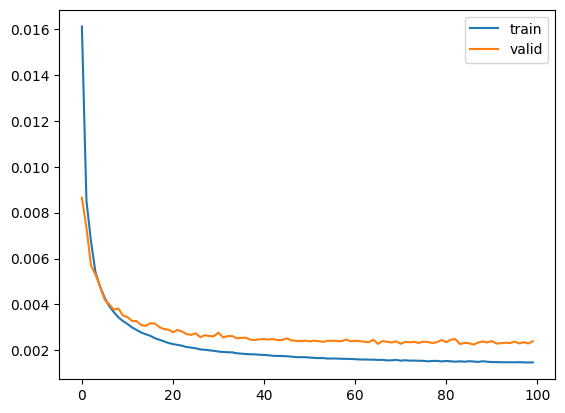

In [42]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [43]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        batch[nan]=0.0
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [44]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_linear = scaler.inverse_transform(test_madrid_normal)

In [45]:
recovery_nn['linear'] = test_linear

19223.47670004051


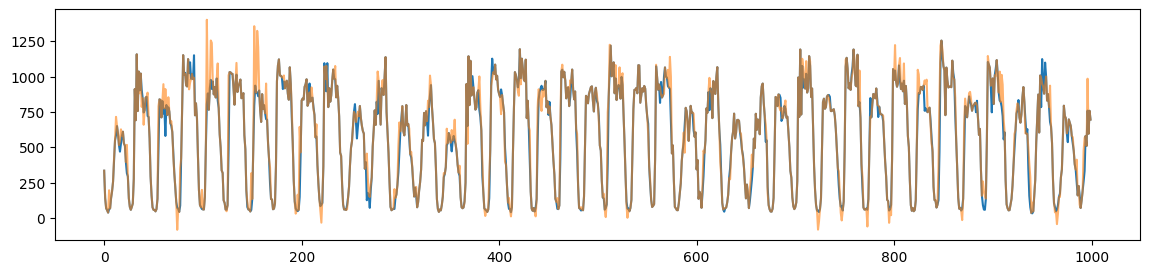

In [47]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_linear[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_linear[index].reshape(1,-1)))

##### 7.2.3 Реккурентная модель востановлениях данных


In [53]:
class EncoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=dim,
                          hidden_size=self.hidden_size)
        
        self.latten = nn.Linear(hidden_size*size_subsequent,latten_size)
        self.leaky = nn.LeakyReLU()
        self.fl = nn.Flatten()
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.leaky(x)
        #print(x.shape)
        x = self.fl(x)
        x = self.latten(x)
        return self.leaky(x)
        

In [54]:
class DecoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.latten_size=latten_size
        self.gru = nn.GRU(input_size=self.hidden_size,
                          hidden_size=dim)
        self.latten = nn.Linear(latten_size,hidden_size*size_subsequent)
        self.leaky = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.latten(x)
        x = x.view(-1, self.size_subsequent, self.latten_size)
        x = self.leaky(x)
        x, _ = self.gru(x)
        return self.leaky(x)
        

In [55]:
class TimeAE(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.encoder = EncoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
        self.decoder = DecoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
    def forward(self, x):
        x=self.encoder(x)
        x = self.decoder(x)
        return x

In [56]:
model = TimeAE(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


epochs = 100

In [57]:
model

TimeAE(
  (encoder): EncoderGRU(
    (gru): GRU(10, 100)
    (latten): Linear(in_features=10000, out_features=100, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
    (fl): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): DecoderGRU(
    (gru): GRU(100, 10)
    (latten): Linear(in_features=100, out_features=10000, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
  )
)

In [59]:
model=model.to(device)
train_history = []
valid_history = []
start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0]==batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            #
            
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0]==batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                # 
                
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

epoch:1 train:0.005667857565271215, valid:0.0048371934866200585
epoch:2 train:0.00420799586293912, valid:0.004097167624507186
epoch:3 train:0.0035405969621891947, valid:0.003608167110112055
epoch:4 train:0.003133067681893021, valid:0.0032865865636154895
epoch:5 train:0.002844720459775107, valid:0.0030663977774192195
epoch:6 train:0.0026280734780819025, valid:0.0028908427194656097
epoch:7 train:0.0024395643169652687, valid:0.002762273224720428
epoch:8 train:0.002310831576114756, valid:0.002648445248762651
epoch:9 train:0.0021598582576168165, valid:0.002507162047550082
epoch:10 train:0.0020520448929119955, valid:0.002424571598165257
epoch:11 train:0.0019568192395221055, valid:0.002385350184284093
epoch:12 train:0.0018743742489295216, valid:0.0022636219126338413
epoch:13 train:0.0018025992480124493, valid:0.0022381309459577926
epoch:14 train:0.001751357673888605, valid:0.002197221281591716
epoch:15 train:0.0016929136809511146, valid:0.002117336496653021
epoch:16 train:0.001646642735534815

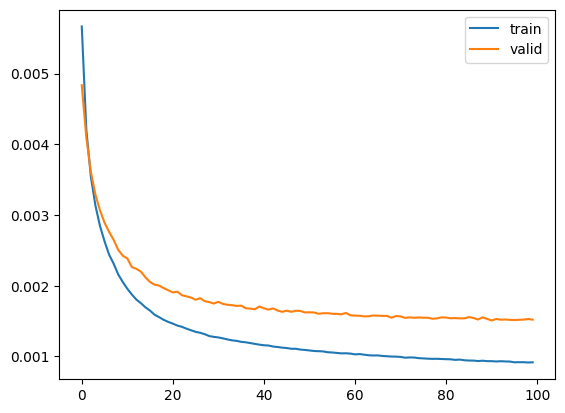

In [60]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [62]:
times_model['ae']=end-start

In [63]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        #
        
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [64]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_ae = scaler.inverse_transform(test_madrid_normal)

In [65]:
recovery_nn['test_ae'] = test_ae

7815.347353696892


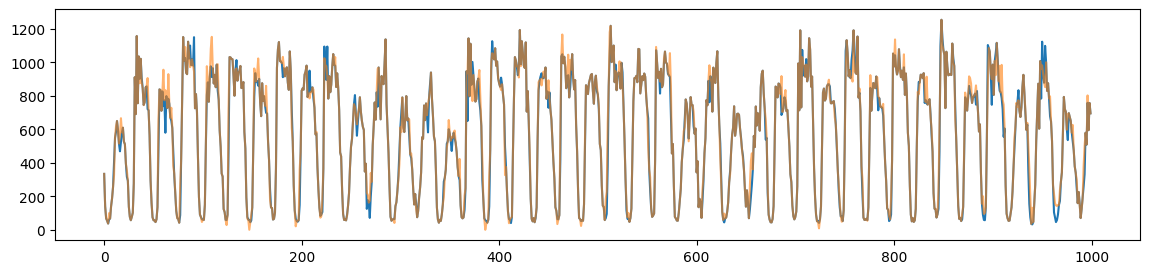

In [66]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_ae[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_ae[index].reshape(1,-1)))

##### 7.2.4 Сложные модели нейросетевого восстановления данных


Вам необходимо выбрать одну модель из 3 группы таблицы 7.2 и используя документацию произвести восстановления того же ряда. Произведите замер времени.

In [ ]:
!pip install pypots==0.0.9

In [67]:
from pypots.imputation import SAITS


In [68]:
model= SAITS(n_features=madrid.shape[1],
             n_steps=100,
             device=device,
             d_k=64,
             d_v=64,
             d_model=128,
             d_inner=128,
             n_head=4,
             n_layers=2,
             dropout=0.05,
             epochs=100)

Model initialized successfully. Number of the trainable parameters: 667608


In [ ]:
start = time.time()
model.fit(train,test)
end = time.time()
times_model['saits']=end-start

epoch 0: training loss 0.1332, validating loss 0.0487
epoch 1: training loss 0.0748, validating loss 0.0418


In [124]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
test_rolling_madrid = model.impute(test_rolling_madrid)


In [125]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_saits = scaler.inverse_transform(test_madrid_normal)

In [130]:
recovery_nn['saits'] = test_saits

4653.035675034267


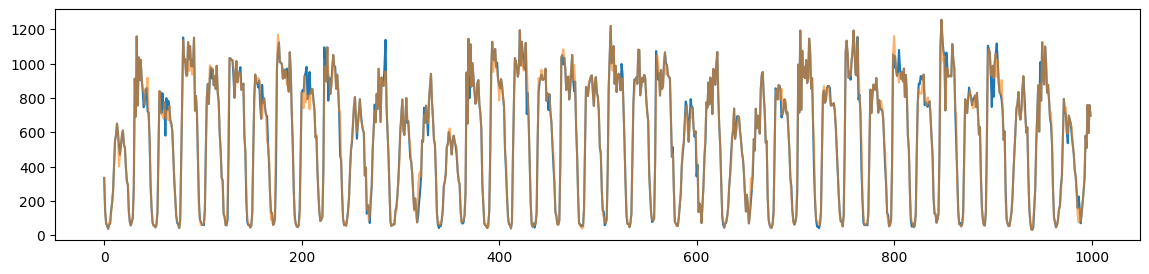

In [126]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_saits[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_saits[index].reshape(1,-1)))

##### 7.2.5 Сравнения результатов.
Также, как и в пункте 7.1.5 постройте графики сравнения моделей. Дополнительно постройте графики сравнения времени. Сделайте выводы

#### **7.3 Прогноз временного ряда**

##### *Краткое описание*

Используя модель и [ARIMA](реализация) произвидите прогноз ряда на следующие колличество точек: 1, 5, 10.
Сравните результаты. Постройте графики прогноза и точности прогноза.